# 02.4 Snell Envelope and Markov Chains

<h3><span style="color:#800000;"><strong>Authored by:</strong> <em>Alexandre Mathias DONNAT, Sr</em></span></h3>

**Goal of this notebook**

- Express the **Snell envelope** in the **Markov chain** framework.  
- Derive the **dynamic programming recursion** for optimal stopping in Markov models.  
- Implement a numerical example using a **finite-state Markov chain**.  
- Visualize the backward induction process leading to the optimal value and stopping region.

**This notebook** 

Bridges probability theory and algorithmic computation turning optimal stopping into an explicit recursive procedure.


# 1. Theoretical Framework

Let $(X_n)_{0 \le n \le N}$ be a **Markov chain** on a finite state space $\mathcal{S}$,  
with transition matrix $P = (p_{ij})_{i,j \in \mathcal{S}}$.

Let $Z_n = g(X_n)$ be the **payoff process**, where $g: \mathcal{S} \to \mathbb{R}_+$.

We consider the optimal stopping problem:
$$
V_0 = \sup_{\tau \in \mathcal{T}} \mathbb{E}[ Z_\tau \mid X_0 = x ].
$$

Under the Markov property, we can define recursively:
$$
\begin{cases}
U_N(x) = g(x), \\
U_n(x) = \max\left( g(x), \sum_{y \in \mathcal{S}} P(x,y) \, U_{n+1}(y) \right),
\end{cases}
$$
for $n = N-1, \dots, 0$.

This is the **dynamic programming equation** for the Snell envelope in Markov models.

# 2. Example: A Simple 3-State Markov Chain

We consider three states:
$$
\mathcal{S} = \{ 0, 1, 2 \}
$$
with transition matrix:

$$
P =
\begin{pmatrix}
0.6 & 0.4 & 0.0 \\
0.2 & 0.6 & 0.2 \\
0.0 & 0.4 & 0.6
\end{pmatrix}.
$$

The payoff function $g(x) = x^2$ rewards higher states.  
We will compute $U_n(x)$ recursively for $N = 3$.


In [1]:
import numpy as np
import pandas as pd

# State space and transition matrix
S = np.array([0, 1, 2])
P = np.array([
    [0.6, 0.4, 0.0],
    [0.2, 0.6, 0.2],
    [0.0, 0.4, 0.6]
])

g = lambda x: x**2
N = 3

U = np.zeros((N+1, len(S)))

# Terminal condition
U[N, :] = g(S)

# Backward recursion
for n in range(N-1, -1, -1):
    exp_val = P @ U[n+1, :]  # E[U_{n+1} | X_n = x]
    U[n, :] = np.maximum(g(S), exp_val)

df = pd.DataFrame(U, columns=[f"x={x}" for x in S])
df.index = [f"n={n}" for n in range(N, -1, -1)]
df

,x=0,x=1,x=2
n=3,1.168,1.992,4.0
n=2,0.800,1.720,4.0
n=1,0.400,1.400,4.0
n=0,0.000,1.000,4.0


## 3. Interpretation of the Resultslts

Each row $n$ gives the Snell envelope values $U_n(x)$ at time $n$ for all states.

At the final step $n = N$, $U_N(x) = g(x)$.

Moving backward, the recursion compares:

- the immediate reward $g(x)$,
- the expected continuation value $\sum_y P(x,y) U_{n+1}(y)$. 

Hence:

- if $g(x) \geq E[U_{n+1} | X_n = x]$ → stop (exercise optimal),
- else → continue (waiting better).


# 4. Visualization of the Backward Recursion

We can visualize how the Snell envelope evolves through time for each state.

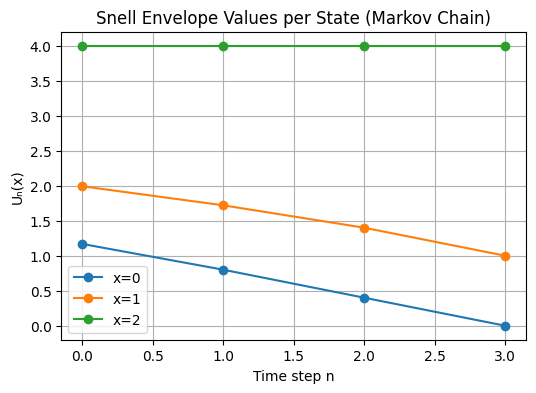

In [2]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
for j, x in enumerate(S):
    plt.plot(range(N+1), U[:, j], '-o', label=f"x={x}")
plt.title("Snell Envelope Values per State (Markov Chain)")
plt.xlabel("Time step n")
plt.ylabel("Uₙ(x)")
plt.legend()
plt.grid(True)
plt.show()

### Notes:

The Snell envelope in a Markov chain is computed fully by backward induction — no simulation is required.

The transition matrix $P$ encodes all probabilistic dynamics.

The recursion ensures that the process $(U_n(X_n))$ forms a supermartingale and defines the optimal stopping rule:

$$\tau^* = \inf\{n : U_n(X_n) = g(X_n)\}$$



# 5. Stopping vs Continuation Regions

We now make the stopping rule explicit by separating, for each time $n$ and state $x$,

- the **stopping region**: where it is optimal to stop, $U_n(x) = g(x)$,  
- the **continuation region**: where it is better to wait, $U_n(x) > g(x)$.

We can visualise this as a grid in $(n, x)$-space.

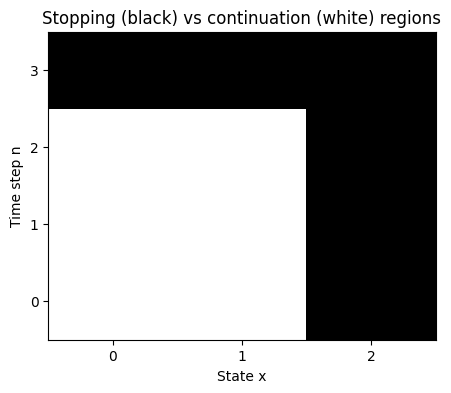

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Boolean matrix: True where stopping is optimal
g_vals = g(S)
stop_region = np.isclose(U, g_vals[None, :])     # shape (N+1, |S|)

plt.figure(figsize=(5, 4))
# Reverse time order on y-axis for nicer display (top = n=0)
plt.imshow(stop_region[::-1, :], cmap="Greys", aspect="auto")

plt.title("Stopping (black) vs continuation (white) regions")
plt.xlabel("State x")
plt.ylabel("Time step n")

# x-axis ticks = states
plt.xticks(ticks=range(len(S)), labels=[f"{x}" for x in S])

# y-axis ticks = time steps (reversed)
plt.yticks(
    ticks=range(U.shape[0]),
    labels=[f"{n}" for n in range(U.shape[0]-1, -1, -1)]
)

plt.grid(False)
plt.show()

### Interpretation

- Each row corresponds to a time step $n$, each column to a state $x \in \{0,1,2\}$.  
- **Black cells** (True) indicate points where $U_n(x) = g(x)$: exercising (stopping) is optimal.  
- **White cells** indicate points where $U_n(x) > g(x)$: continuation is preferred, the process remains "alive".

This picture makes the optimal stopping rule fully explicit in the Markov setting:
$$
\tau^* = \inf\{ n : U_n(X_n) = g(X_n) \},
$$
and clearly separates **stopping** from **continuation** regions, just like we will do for American options in the next notebook.
